In [44]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from pathlib import Path
from matplotlib import colormaps #type: ignore

In [45]:
sv = False
dpi = 500
transparent = False
task = 'alpaca'
layers = 12

methods = {
    'lora': {'lr': 2e-5, 'bs': 2, 'layers': 0, 'color': 'blue', 'label': 'LoRA', 'marker': 'o', 'linestyle': '-'},
    'rslora': {'lr': 2e-5, 'bs': 2, 'layers': 0, 'color': 'green', 'label': 'RsLoRA', 'marker': 's', 'linestyle': '-'},
    'alpha': {'lr': 2e-6, 'bs': 2, 'layers': layers, 'color': 'red', 'label': 'Alpha', 'marker': '^', 'linestyle': '-'},
    'full': {'lr': 2e-7, 'bs': 2, 'layers': 250, 'color': 'purple', 'label': 'Full', 'marker': 'x', 'linestyle': '-'},
    'dora': {'lr': 2e-5, 'bs': 2, 'layers': 0, 'color': 'orange', 'label': 'DORA', 'marker': 'd', 'linestyle': '-'},
}

lora_lr= methods['lora']['lr']
rslora_lr= methods['rslora']['lr']
alpha_lr = methods['alpha']['lr']
full_lr = methods['full']['lr']

lora_b = methods['lora']['bs']
alpha_b = methods['alpha']['bs']
full_b = methods['full']['bs']

pth = f'/rscratch/tpang/kinshuk/RpMKin/LlaMAft/Plots/{task}'
if sv:
    print(os.getcwd())
    pth = os.path.join(os.getcwd(), pth)
    Path(pth).mkdir(parents=True, exist_ok=True)
    print(pth)

paths = {}

for k,v in methods.items():
    paths[k] = f'./output/{task}/lr_{methods[k]["lr"]}/batch_{methods[k]["bs"]}/{k}/layers_{methods[k]["layers"]}'

dictionary = {}
for k,v in paths.items():
    dictionary[k] = {'train_loss': [], 'time': []}

In [46]:
for key in dictionary.keys():
    path = paths[key]
    path = os.path.join(path, "finetune.npy")
    baseline = np.load(path, allow_pickle=True).item()
    for key2 in dictionary[key].keys():
        dictionary[key][key2].append(baseline[key2])
        dictionary[key][key2] = np.array(dictionary[key][key2]) # type: ignore

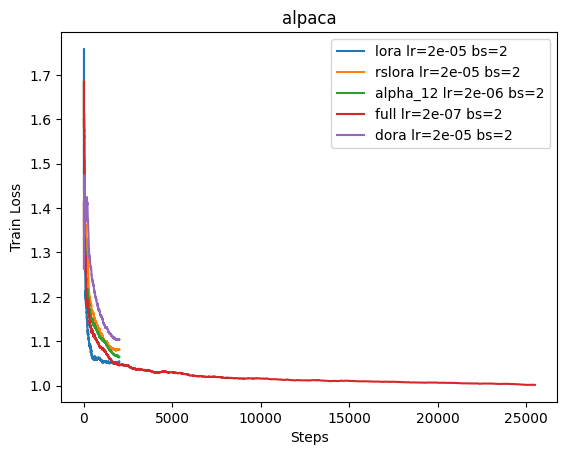

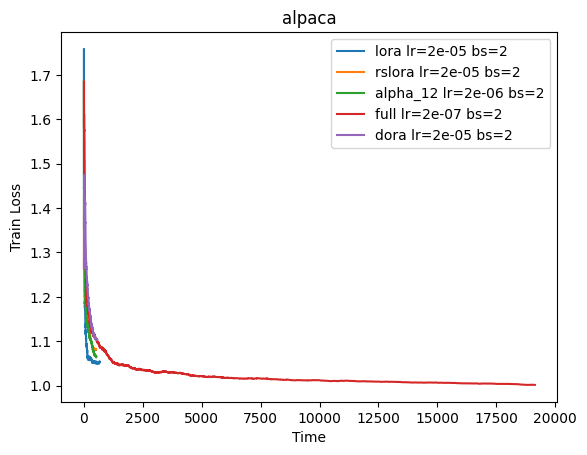

In [47]:
for key in dictionary.keys():
    tag = key + f" lr={methods[key]['lr']} bs={methods[key]['bs']}"
    if 'alpha' in key:
        tag = key + f"_{layers} lr={methods[key]['lr']} bs={methods[key]['bs']}"
    plt.plot(dictionary[key]['train_loss'][0], label=tag)
    plt.xlabel("Steps")
    plt.ylabel("Train Loss")
plt.legend()
plt.title(f"{task}")
plt.show()

for key in dictionary.keys():
    tag = key + f" lr={methods[key]['lr']} bs={methods[key]['bs']}"
    if 'alpha' in key:
        tag = key + f"_{layers} lr={methods[key]['lr']} bs={methods[key]['bs']}"
    plt.plot(dictionary[key]['time'][0],dictionary[key]['train_loss'][0], label=tag)
    plt.xlabel("Time")
    plt.ylabel("Train Loss")
plt.legend()
plt.title(f"{task}")
plt.show()

# exit()

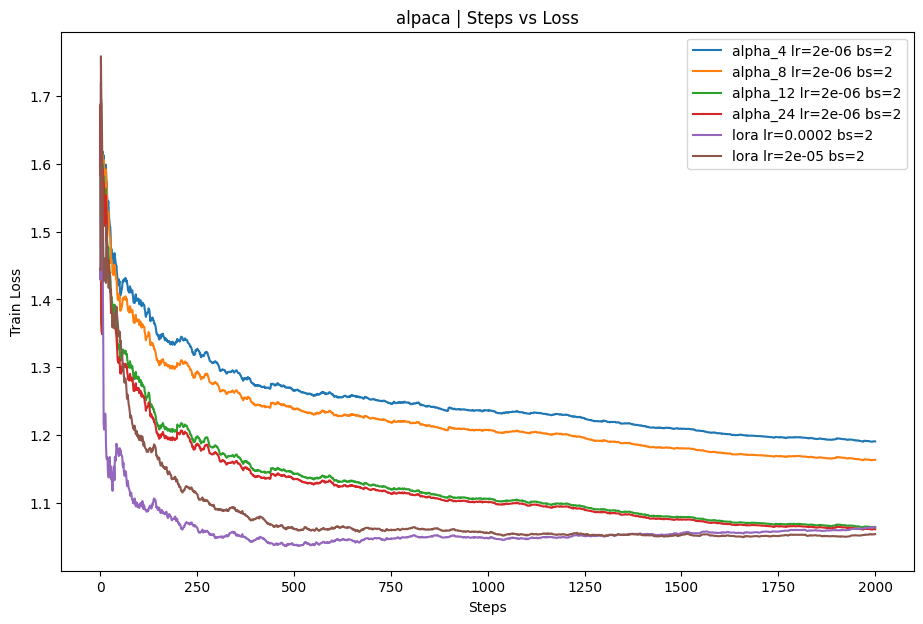

In [48]:
cmp = 'viridis'
dpi = 500
transparent = False
task = 'alpaca'

lora_lr=2e-4
alpha_lr = 2e-6

lora_b = 2
alpha_b = 2
layers = 12

plt.figure(figsize=(11, 7))
for layers in [4,8,12,24]:
    paths = {
    'lora': f"./output/{task}/lr_{lora_lr}/batch_{lora_b}/lora/layers_0",
    'alpha': f"./output/{task}/lr_{alpha_lr}/batch_{alpha_b}/alpha/layers_{layers}"
    }
    dictionary = {
    "lora" :  {'train_loss': [], 'time': []},
    "alpha" : {'train_loss': [], 'time': []},
    }

    for key in dictionary.keys():
        path = paths[key]
        path = os.path.join(path, "finetune.npy")
        baseline = np.load(path, allow_pickle=True).item()
        for key2 in dictionary[key].keys():
            dictionary[key][key2].append(baseline[key2])
            dictionary[key][key2] = np.array(dictionary[key][key2])
    
    # load memlog.log from lora_path and alpha_path and print it

    # for key in dictionary.keys():
    #     memlog = os.path.join(paths[key], "memlog.log")
    #     with open(memlog, 'r') as f:
    #         memlog = f.readlines()
    #     memlog = memlog[4:]
    #     memlog = "".join(memlog)
    #     print(memlog, end='')
    key = 'alpha'
    tag = key + f"_{layers} lr={alpha_lr} bs={alpha_b}"
    plt.plot(dictionary[key]['train_loss'][0], label=tag)
key = 'lora'
tag = key + f"_{layers} lr={alpha_lr} bs={alpha_b}"
if 'lora' in key:
    tag = key + f" lr={lora_lr} bs={lora_b}"
plt.plot(dictionary[key]['train_loss'][0], label=tag)


cmp = 'viridis'
dpi = 500
transparent = False
task = 'alpaca'

lora_lr=2e-5
alpha_lr = 2e-6

lora_b = 2
alpha_b = 2
layers = 12

for layers in [4,8,12,24]:
    paths = {
    'lora': f"./output/{task}/lr_{lora_lr}/batch_{lora_b}/lora/layers_0",
    'alpha': f"./output/{task}/lr_{alpha_lr}/batch_{alpha_b}/alpha/layers_{layers}"
    }
    dictionary = {
    "lora" :  {'train_loss': [], 'time': []},
    "alpha" : {'train_loss': [], 'time': []},
    }

    for key in dictionary.keys():
        path = paths[key]
        path = os.path.join(path, "finetune.npy")
        baseline = np.load(path, allow_pickle=True).item()
        for key2 in dictionary[key].keys():
            dictionary[key][key2].append(baseline[key2])
            dictionary[key][key2] = np.array(dictionary[key][key2])
    
    # load memlog.log from lora_path and alpha_path and print it
key = 'lora'
tag = key + f"_{layers} lr={alpha_lr} bs={alpha_b}"
if 'lora' in key:
    tag = key + f" lr={lora_lr} bs={lora_b}"
plt.plot(dictionary[key]['train_loss'][0], label=tag)


plt.xlabel("Steps")
plt.ylabel("Train Loss")
plt.legend()
plt.title(f"{task} | Steps vs Loss")

# plt.savefig(f'Alpaca_steps_loss.png', transparent=transparent, dpi=dpi, bbox_inches='tight')
plt.show()

    

(6758.412288, 19.98848)
Dataset          : oasst1
Method           : lora
Layers           : 0
Batch size       : 4
Learning Rate    : 0.0002
Forward time     : 6.448310494422913 min
Backward time    : 13.096387807528178 min
Weight memory    : 27167.883264 MB
Optimizer memory : 159.90784 MB
Activation memory: 12593.586688 MB
Gradient memory  : 229.114368 MB
Input memory     : 0.018944 MB
Total memory     : 27476.970496 MB
Peak memory      : 40351.6416 MB


(6738.423808, 360.71424)
Dataset          : oasst1
Method           : alpha
Layers           : 12
Batch size       : 2
Learning Rate    : 2e-06
Forward time     : 1.6859593947728475 min
Backward time    : 6.039054278532664 min
Weight memory    : 27087.929344 MB
Optimizer memory : 2885.71392 MB
Activation memory: 4550.16448 MB
Gradient memory  : 1525.691392 MB
Input memory     : 0.01024 MB
Total memory     : 30056.487936 MB
Peak memory      : 35118.135808 MB


(6758.412288, 19.98848)
Dataset          : oasst1
Method           : lora
L

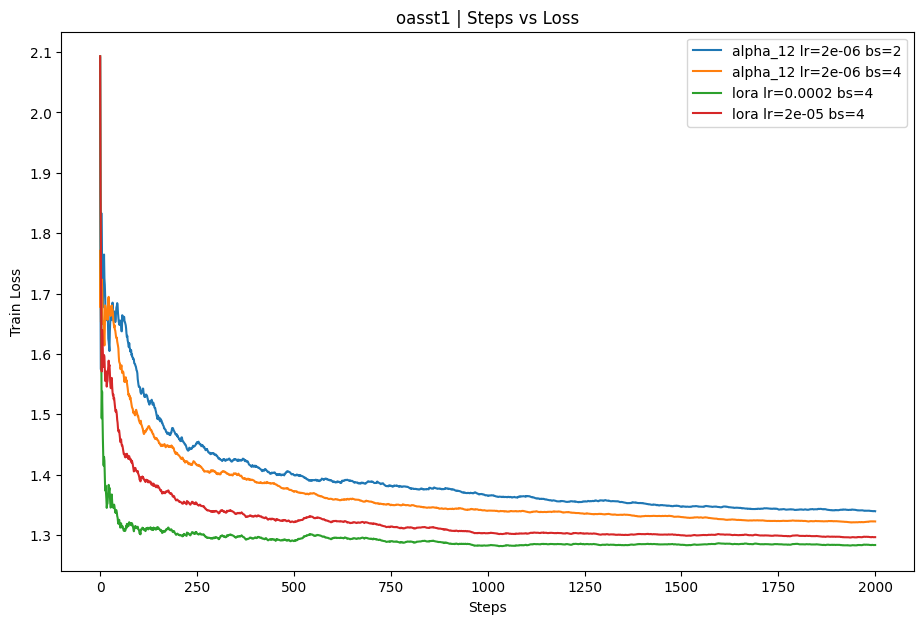

In [49]:
cmp = 'viridis'
dpi = 500
transparent = False
task = 'oasst1'

lora_lr=2e-4
alpha_lr = 2e-6

lora_b = 4
alpha_b = 2
layers = 12

plt.figure(figsize=(11, 7))
for alpha_b in [2,4]:
    paths = {
    'lora': f"./output/{task}/lr_{lora_lr}/batch_{lora_b}/lora/layers_0",
    'alpha': f"./output/{task}/lr_{alpha_lr}/batch_{alpha_b}/alpha/layers_{layers}"
    }
    dictionary = {
    "lora" :  {'train_loss': [], 'time': []},
    "alpha" : {'train_loss': [], 'time': []},
    }

    for key in dictionary.keys():
        path = paths[key]
        path = os.path.join(path, "finetune.npy")
        baseline = np.load(path, allow_pickle=True).item()
        for key2 in dictionary[key].keys():
            dictionary[key][key2].append(baseline[key2])
            dictionary[key][key2] = np.array(dictionary[key][key2])
    
    # load memlog.log from lora_path and alpha_path and print it

    for key in dictionary.keys():
        memlog = os.path.join(paths[key], "memlog.log")
        with open(memlog, 'r') as f:
            memlog = f.readlines()
        memlog = memlog[4:]
        memlog = "".join(memlog)
        print(memlog, end='')
    key = 'alpha'
    tag = key + f"_{layers} lr={alpha_lr} bs={alpha_b}"
    plt.plot(dictionary[key]['train_loss'][0], label=tag)
key = 'lora'
tag = key + f"_{layers} lr={alpha_lr} bs={alpha_b}"
if 'lora' in key:
    tag = key + f" lr={lora_lr} bs={lora_b}"
plt.plot(dictionary[key]['train_loss'][0], label=tag)


lora_lr=2e-5

layers = 12

for alpha_b in [2,4]:
    paths = {
    'lora': f"./output/{task}/lr_{lora_lr}/batch_{lora_b}/lora/layers_0",
    'alpha': f"./output/{task}/lr_{alpha_lr}/batch_{alpha_b}/alpha/layers_{layers}"
    }
    dictionary = {
    "lora" :  {'train_loss': [], 'time': []},
    "alpha" : {'train_loss': [], 'time': []},
    }

    for key in dictionary.keys():
        path = paths[key]
        path = os.path.join(path, "finetune.npy")
        baseline = np.load(path, allow_pickle=True).item()
        for key2 in dictionary[key].keys():
            dictionary[key][key2].append(baseline[key2])
            dictionary[key][key2] = np.array(dictionary[key][key2])
    
    # load memlog.log from lora_path and alpha_path and print it

    for key in dictionary.keys():
        memlog = os.path.join(paths[key], "memlog.log")
        with open(memlog, 'r') as f:
            memlog = f.readlines()
        memlog = memlog[4:]
        memlog = "".join(memlog)
        print(memlog, end='')
key = 'lora'
tag = key + f"_{layers} lr={alpha_lr} bs={alpha_b}"
if 'lora' in key:
    tag = key + f" lr={lora_lr} bs={lora_b}"
plt.plot(dictionary[key]['train_loss'][0], label=tag)

plt.xlabel("Steps")
plt.ylabel("Train Loss")
plt.legend()
plt.title(f"{task} | Steps vs Loss")

# plt.savefig(f'{task}_loss_steps.png', transparent=transparent, dpi=dpi, bbox_inches='tight')
plt.show()

    

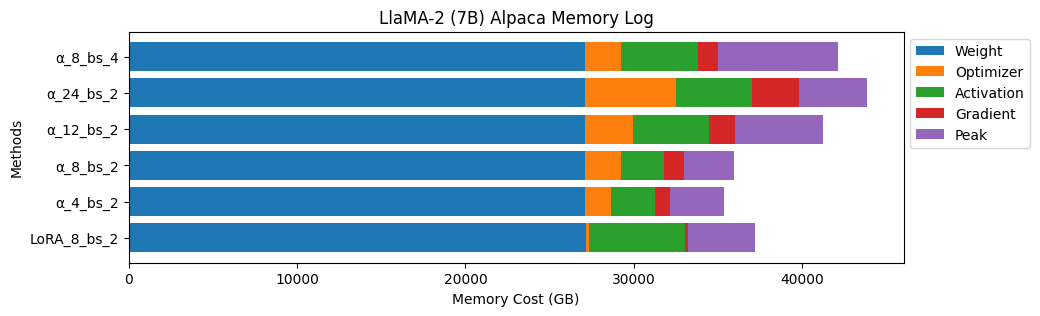

In [50]:
# Alpaca_Data
plt.figure(figsize=(10, 3))
categories = ['LoRA_8_bs_2', 'α_4_bs_2', 'α_8_bs_2', 'α_12_bs_2', 'α_24_bs_2', 'α_8_bs_4']
Weight = [27167.883264, 27087.929344, 27087.929344, 27087.929344, 27087.929344, 27087.929344]
Optimizer =  [159.90784, 1585.47968, 2122.350592, 2885.71392, 5402.29632, 2122.350592]
Activation = [5737.52832, 2575.353344, 2604.649472, 4503.892992, 4546.884608, 4574.863872]
Gradient =   [157.92384, 875.31776, 1143.753216, 1525.43488, 2784.250368, 1193.931264]
Peak = [37186.260992, 35369.175552, 35976.432128, 41205.979136, 43821.993984, 42142.918144]

#Reduce other memory from peak
Weight = np.array(Weight)
Optimizer = np.array(Optimizer)
Activation = np.array(Activation)
Gradient = np.array(Gradient)
Peak = np.array(Peak)
Peak = Peak - (Weight + Optimizer + Activation + Gradient)

plt.barh(categories, Weight, label='Weight')

plt.barh(categories, Optimizer, label='Optimizer',  left=Weight)

plt.barh(categories, Activation, label='Activation',  left=Weight+Optimizer)

plt.barh(categories, Gradient, label='Gradient',  left=Weight+Optimizer+Activation)

plt.barh(categories, Peak, label='Peak',  left=Weight+Optimizer+Activation+Gradient)

# Adding labels and title
plt.xlabel('Memory Cost (GB)')
plt.ylabel('Methods')
plt.title('LlaMA-2 (7B) Alpaca Memory Log')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

# Displaying the graph
# plt.savefig(f'Alpaca_Memory_log', transparent=transparent, dpi=dpi, bbox_inches='tight')
plt.show()


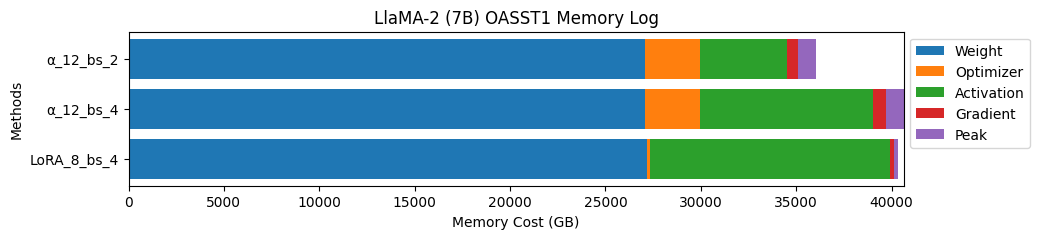

In [51]:
# Alpaca_Data
plt.figure(figsize=(10, 2))
categories = ['LoRA_8_bs_4', 'α_12_bs_4', 'α_12_bs_2']
Weight = [27167.883264, 27087.929344, 27087.929344]
Optimizer =  [159.90784, 2885.71392, 2885.71392]
Activation = [12593.586688, 9063.457792, 4550.16448]
Gradient =   [229.114368, 1592.017408, 1525.691392]
Peak = [40351.6416, 39729.840128, 35118.135808]

#Reduce other memory from peak
Weight = np.array(Weight)
Optimizer = np.array(Optimizer)
Activation = np.array(Activation)
Gradient = np.array(Gradient)
Peak = np.array(Peak)
Peak = Peak - (Weight + Optimizer + Activation + Gradient)

plt.barh(categories, Weight, label='Weight')

plt.barh(categories, Optimizer, label='Optimizer',  left=Weight)

plt.barh(categories, Activation, label='Activation',  left=Weight+Optimizer)

plt.barh(categories, Gradient, label='Gradient',  left=Weight+Optimizer+Activation)

plt.barh(categories, Peak, label='Peak',  left=Weight+Optimizer+Activation+Gradient)

# Adding labels and title
plt.xlabel('Memory Cost (GB)')
plt.ylabel('Methods')
plt.title('LlaMA-2 (7B) OASST1 Memory Log')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

# Displaying the graph
# plt.savefig(f'OASST1_Memory_log', transparent=transparent, dpi=dpi, bbox_inches='tight')
plt.show()
